# Test file

Here we test other approaches which may be promising

In [16]:
import qutip
from functions import *

## Looking for states that work

In [17]:
N_binom = 20
N = N_binom
rho_binom = qutip.ket2dm((qutip.fock(N, 0) + qutip.fock(N, 4)).unit())
noisy_rho_binom = create_states(N, [1], rho_binom, 0.1)[0]
vd_rho_binom = (noisy_rho_binom**3/(noisy_rho_binom**3).tr())

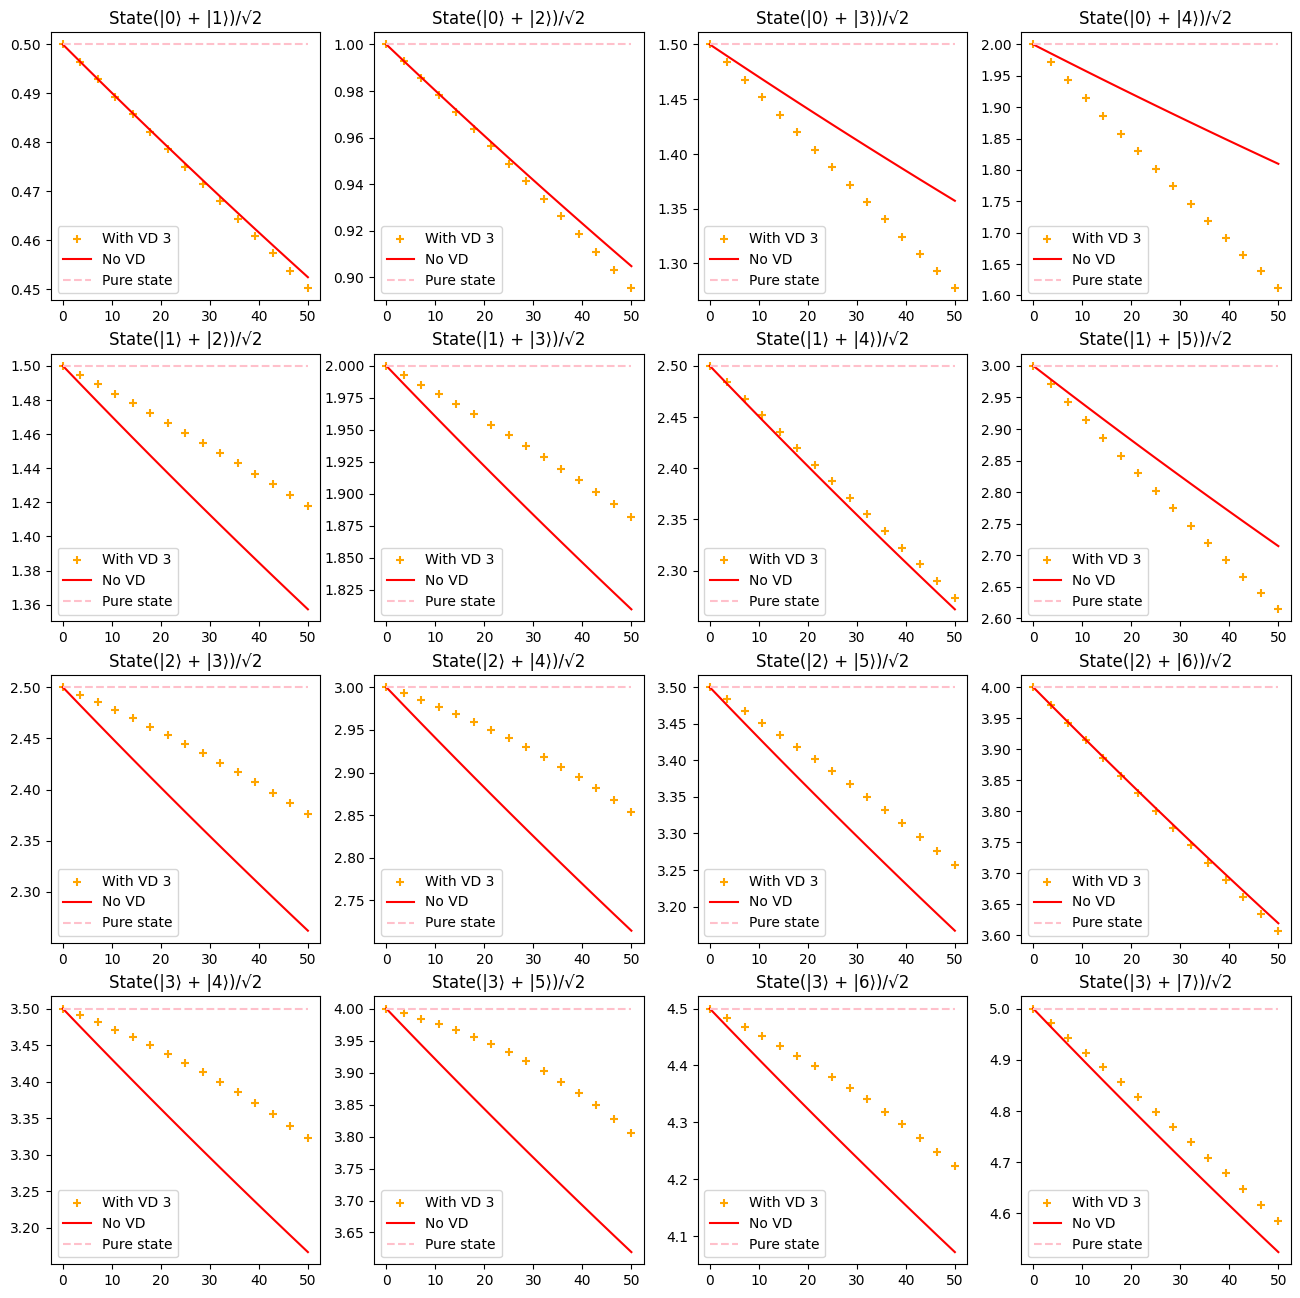

In [18]:
N=N_binom
def plot_th(rho, N, f, ax, title):
    t_list = np.linspace(0, 50, 15)
    kappa = 1/500
    noisy_rho_list = create_states(N, t_list, rho, kappa)
    vd_list = [noisy_rho**3/(noisy_rho**3).tr() for noisy_rho in noisy_rho_list]

    photon_number_no_vd = [qutip.expect(qutip.num(N), noisy_rho) for noisy_rho in noisy_rho_list]
    photon_number_vd = [qutip.expect(qutip.num(N), vd_rho) for vd_rho in vd_list]

    photon_number_vd_inf_th = 2*(2*np.exp(-4*kappa*t_list))/(1+np.exp(-4*kappa*t_list))
    #ax.scatter(t_list, photon_number_no_vd, label="Without VD", c='r', marker='+')
    ax.scatter(t_list, photon_number_vd, label="With VD 3", c='orange', marker='+')
    #plt.plot(t_list, photon_number_vd_inf_th, label="VD inf limit", c='orange')
    init_photon_number = qutip.expect(qutip.num(N), rho)
    ax.plot(t_list, init_photon_number*np.exp(-kappa*t_list), c='r', label='No VD')
    ax.plot(t_list, np.full_like(t_list, init_photon_number), label="Pure state", c='pink', linestyle='dashed')
    ax.legend()
    ax.set_title("State" + title)
    #ax.set_xlabel("Time (μs)")

size=4
fig, ax = plt.subplots(size, size, figsize=(16, 16))
#fig.suptitle("Measuring number operator using Virtual Distillation on noisy generalized binomial states")
for i in range(size):
    for j in range(size):
        rho = qutip.ket2dm((qutip.fock(N, i) + qutip.fock(N, i+j+1)).unit())
        plot_th(rho, N, fig, ax[i][j], f"(|{i}⟩ + |{i+j+1}⟩)/√2")

In most of the cases there is a benefit (yellow points above the red curve) ! The protocol breaks down when the first term is $\ket0$ or when the second term is too far from the first one.

# ----- Theoretical plots -----
Let’s look at some scaling for high Fock states or high number of modes

In [19]:
nb_points = 1000
nb_curves = 9 # modes, starts at 1
nb_n = 50 # Fock state, starts at 1
gamma_list_complete = np.linspace(0,1,nb_points)
theoretical_curves = np.zeros((nb_n, nb_curves, nb_points))
names = [["" for j in range(nb_curves)] for i in range(nb_n)]

for n_ in range(1,nb_n+1):
    theoretical_curves[n_-1][0] = n_ * np.exp(-gamma_list_complete)
    names[n_-1][0] = f"No VD, state |{n_}>"

kappa = 1/500
temporary = (np.exp(kappa * gamma_list_complete)-1)
for n_ in range(1,nb_n+1):
    for M in range(1,nb_curves):
        numerator = np.zeros_like(gamma_list_complete, dtype='O')
        denominator = np.zeros_like(gamma_list_complete, dtype='O')
        for k in range(n_+1):
            coef = (math.comb(n_, k)**M)
            numerator+=(n_-k)*coef *temporary**(M*k)
            denominator+=coef *temporary**(M*k)
        theoretical_curves[n_-1][M] = numerator/denominator
        names[n_-1][M] = f"{M+1}-mode VD, state |{n_}>"

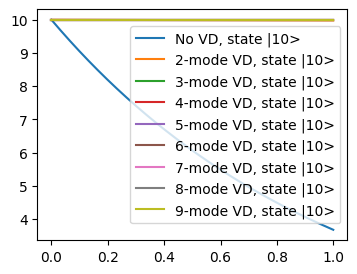

In [20]:
plt.figure(figsize=(4, 3))
for i in range(9,10):
    for j in range(nb_curves):
        plt.plot(gamma_list_complete, theoretical_curves[i][j], label=names[i][j])
plt.legend()

0.10010010010010009


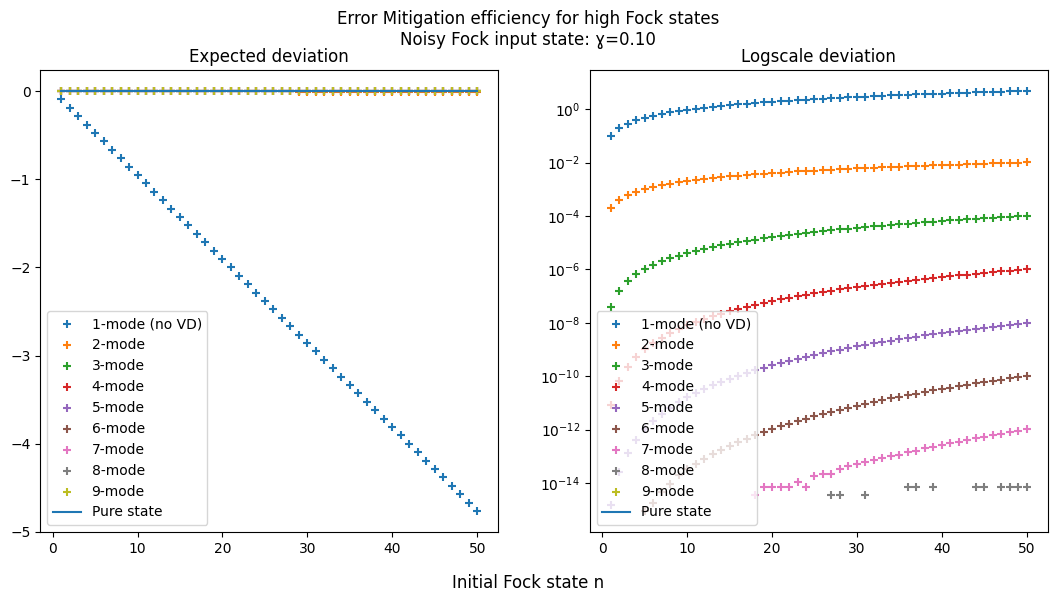

In [21]:
f, axes = plt.subplots(1, 2, figsize=(13,6))
fixed_gamma_index=100
for j in range(nb_curves):
    axes[0].scatter(np.arange(1,nb_n+1), theoretical_curves[:,j,fixed_gamma_index] -np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
    axes[1].scatter(np.arange(1,nb_n+1), -theoretical_curves[:,j,fixed_gamma_index] + np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
axes[0].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )
axes[1].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )

axes[0].legend()
axes[0].set_title("Expected deviation")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Logscale deviation")

f.supxlabel("Initial Fock state n")
f.suptitle(f"Error Mitigation efficiency for high Fock states\nNoisy Fock input state: ɣ={gamma_list_complete[fixed_gamma_index]:.2f}")

print(gamma_list_complete[fixed_gamma_index])

On the right plot we see pretty clearly the exponential scaling of the correction as the number of modes increases. In fact, the spacing is the same between each curve, because we are looking at $\log(p^M)=M*\log p$ for different values of M.

We also see that the deviation seems to stabilize, but looking at the left plot it rather seems that it grows linearly with $n$.

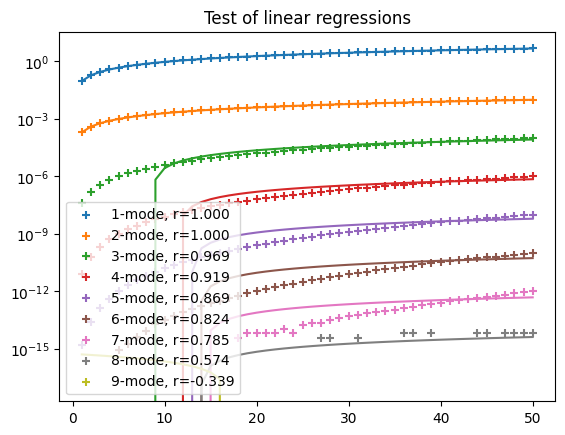

In [22]:
import scipy.stats as sts
x = np.arange(1, nb_n+1)
for j in range(nb_curves):
    a = x-theoretical_curves[:,j,fixed_gamma_index]
    slope, intercept, r, p, se = sts.linregress(x, a)
    plt.scatter(x, a, marker='+', label=f"{j+1}-mode, r={r:.3f}")
    plt.plot(x, slope*x+intercept)
plt.yscale("log")
plt.title("Test of linear regressions")
plt.legend()

Ok for few modes but as soon as we go further it’s not that clear


## Eigenvector analysis

In [23]:
# find eigenvectors of this array
def print_eigen(rho, N, threshold=1e-5):
    ''' Prints eigenvalues and eigenvectors of the density matrix rho, with a threshold for the coefficients
    Returns the dominant eigenvector'''
    eigvals, eigvecs = np.linalg.eig(rho.data.toarray())
    #p = eigvals.argsort(0); inv = np.empty_like(p);   inv[p] = np.arange(p.size)
    #eigvals = eigvals[p[::-1]]
    #eigvecs = eigvecs[p[::-1]]
    #print(eigvals); print(eigvecs)
    for (i, eigval) in enumerate(eigvals):
        if eigval.real<threshold: continue
        s=""
        for j in range(N):
            coef = eigvecs[j][i]
            if abs(coef)>threshold:
                if s!="": s+= " + "
                s += f"{(coef.real if coef.imag<threshold else coef):.3f}|{j}⟩⟨{j}|"
        print(f"Probability {eigval.real:.2f}: {s}")
    return eigvecs[:,np.argmax(eigvals)]
N = N_binom
print_eigen(noisy_rho_binom, N_binom)

Probability 0.84: 0.774|0⟩⟨0| + 0.633|4⟩⟨4|
Probability 0.00: -0.633|0⟩⟨0| + 0.774|4⟩⟨4|
Probability 0.00: 1.000|1⟩⟨1|
Probability 0.02: 1.000|2⟩⟨2|
Probability 0.14: 1.000|3⟩⟨3|


array([ 0.77376434+0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
        0.63347356-0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
       -0.        -0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
       -0.        -0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
       -0.        -0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j])

In [24]:
qutip.expect(qutip.num(N), noisy_rho_binom), qutip.expect(qutip.num(N), vd_rho_binom)

(1.809674836071919, 1.6118413779016183)

GKP

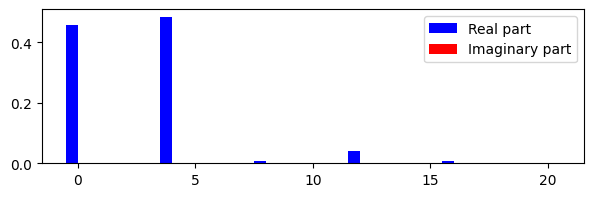

In [25]:
N = 21
psi_gkp = gkp_state(0.4, N)
rho_gkp = qutip.ket2dm(psi_gkp)
plt.figure(figsize=(7,2))
plt.bar(np.arange(N)-0.25, np.real(np.diag(rho_gkp)), width=0.5, color='b', label='Real part')
plt.bar(np.arange(N)+0.25, np.imag(np.diag(rho_gkp)), width=0.5, color='r', label='Imaginary part')
plt.legend()

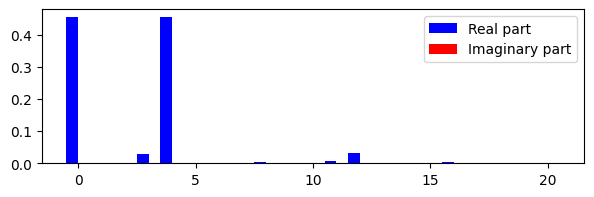

In [26]:
gamma_list = np.linspace(0,0.2,40)
noisy_gkp_list = create_states(N, gamma_list, rho_gkp, 1)

plt.figure(figsize=(7,2))
plt.bar(np.arange(N)-0.25, np.real(np.diag(noisy_gkp_list[3])), width=0.5, color='b', label='Real part')
plt.bar(np.arange(N)+0.25, np.imag(np.diag(noisy_gkp_list[3])), width=0.5, color='r', label='Imaginary part')
plt.legend()

In [27]:
dom_eigen = print_eigen(noisy_gkp_list[-1], N, threshold=1e-3)

Probability 0.68: 0.820|0⟩⟨0| + -0.005|2⟩⟨2| + 0.566|4⟩⟨4| + 0.021|6⟩⟨6| + -0.042|8⟩⟨8| + -0.005|10⟩⟨10| + 0.074|12⟩⟨12| + 0.004|14⟩⟨14| + 0.020|16⟩⟨16| + 0.005|18⟩⟨18| + -0.005|20⟩⟨20|
Probability 0.08: -0.020|0⟩⟨0| + 0.896|2⟩⟨2| + 0.040|4⟩⟨4| + -0.147|6⟩⟨6| + -0.022|8⟩⟨8| + 0.386|10⟩⟨10| + 0.020|12⟩⟨12| + 0.143|14⟩⟨14| + 0.042|16⟩⟨16| + -0.048|18⟩⟨18|
Probability 0.21: -0.005|1⟩⟨1| + 0.967|3⟩⟨3| + 0.043|5⟩⟨5| + -0.105|7⟩⟨7| + -0.013|9⟩⟨9| + 0.217|11⟩⟨11| + 0.011|13⟩⟨13| + 0.070|15⟩⟨15| + 0.019|17⟩⟨17| + -0.020|19⟩⟨19|
Probability 0.01: 0.181|0⟩⟨0| + -0.008|2⟩⟨2| + -0.250|4⟩⟨4| + -0.030|6⟩⟨6| + 0.819|8⟩⟨8| + 0.038|10⟩⟨10| + 0.420|12⟩⟨12| + 0.137|14⟩⟨14| + -0.190|16⟩⟨16| + 0.002|18⟩⟨18|
Probability 0.02: 0.669|1⟩⟨1| + 0.004|3⟩⟨3| + -0.191|5⟩⟨5| + -0.027|7⟩⟨7| + 0.645|9⟩⟨9| + 0.030|11⟩⟨11| + 0.283|13⟩⟨13| + 0.086|15⟩⟨15| + -0.108|17⟩⟨17| + 0.001|19⟩⟨19|
Probability 0.00: -0.037|1⟩⟨1| + -0.019|3⟩⟨3| + -0.011|5⟩⟨5| + 0.786|7⟩⟨7| + 0.006|9⟩⟨9| + 0.536|11⟩⟨11| + 0.167|13⟩⟨13| + -0.255|15⟩⟨1

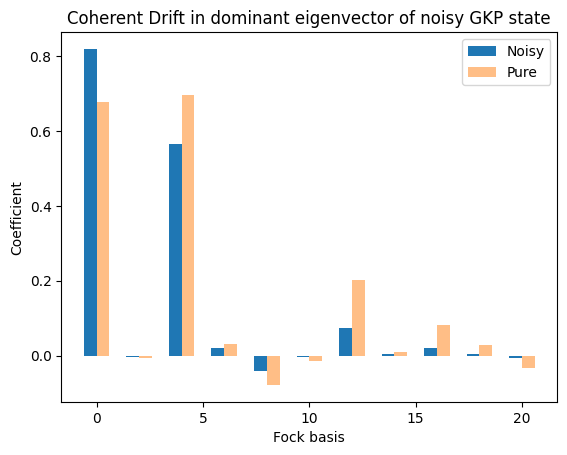

In [28]:
plt.bar(np.arange(N)-0.3, np.real(dom_eigen), width=0.6, label="Noisy")
plt.bar(np.arange(N)+0.3, np.real(psi_gkp.full().flatten()), width=0.6,alpha=0.5, label="Pure")
plt.title("Coherent Drift in dominant eigenvector of noisy GKP state")
plt.xlabel("Fock basis")
plt.ylabel("Coefficient")
plt.legend()

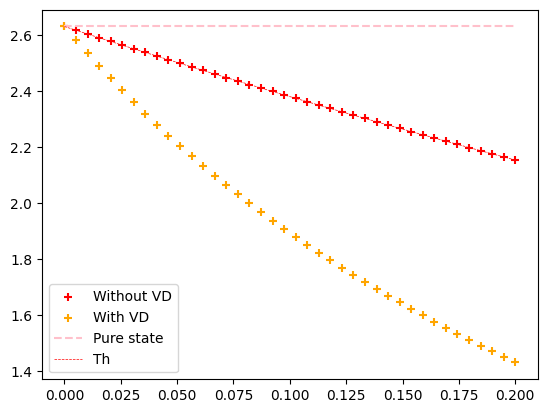

In [29]:
N=21
no_VD_result_list = [qutip.expect(qutip.num(N), rho) for rho in noisy_gkp_list]
VD_result_list = [qutip.expect(qutip.num(N), rho**3/(rho**3).tr()) for rho in noisy_gkp_list]
# plot a scatter with the results
plt.scatter(gamma_list, no_VD_result_list, label="Without VD", c='r', marker='+')
plt.scatter(gamma_list, VD_result_list, label="With VD", c='orange', marker='+')
init_photon_number = qutip.expect(qutip.num(N), psi_gkp)
plt.plot(gamma_list, np.full_like(gamma_list, init_photon_number), label="Pure state", c='pink', linestyle='dashed')
plt.plot(gamma_list, np.exp(-gamma_list)*init_photon_number, label="Th",linewidth=0.5, c='r', linestyle='dashed')
plt.legend()

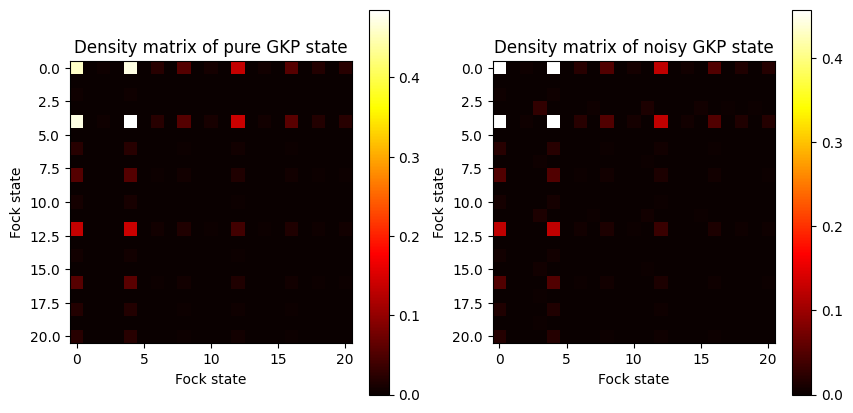

In [30]:
def density_matrix_color_map(rho, title, fig, ax):
    ''' Plots the density matrix rho in a color map'''
    p = ax.imshow(np.abs(rho.full()), cmap='hot', interpolation='nearest')
    fig.colorbar(p)
    ax.set_title("Density matrix of " + title)
    ax.set_xlabel("Fock state")
    ax.set_ylabel("Fock state")

fig, ax = plt.subplots(1,2, figsize=(10,5))
density_matrix_color_map(rho_gkp, "pure GKP state", fig, ax[0])
density_matrix_color_map(noisy_gkp_list[3], "noisy GKP state", fig, ax[1])

## Symmetry breaking experiments

Text(0.5, 0.98, 'Wigner functions of noisy Fock state |2⟩ after loss and dephasing channel')

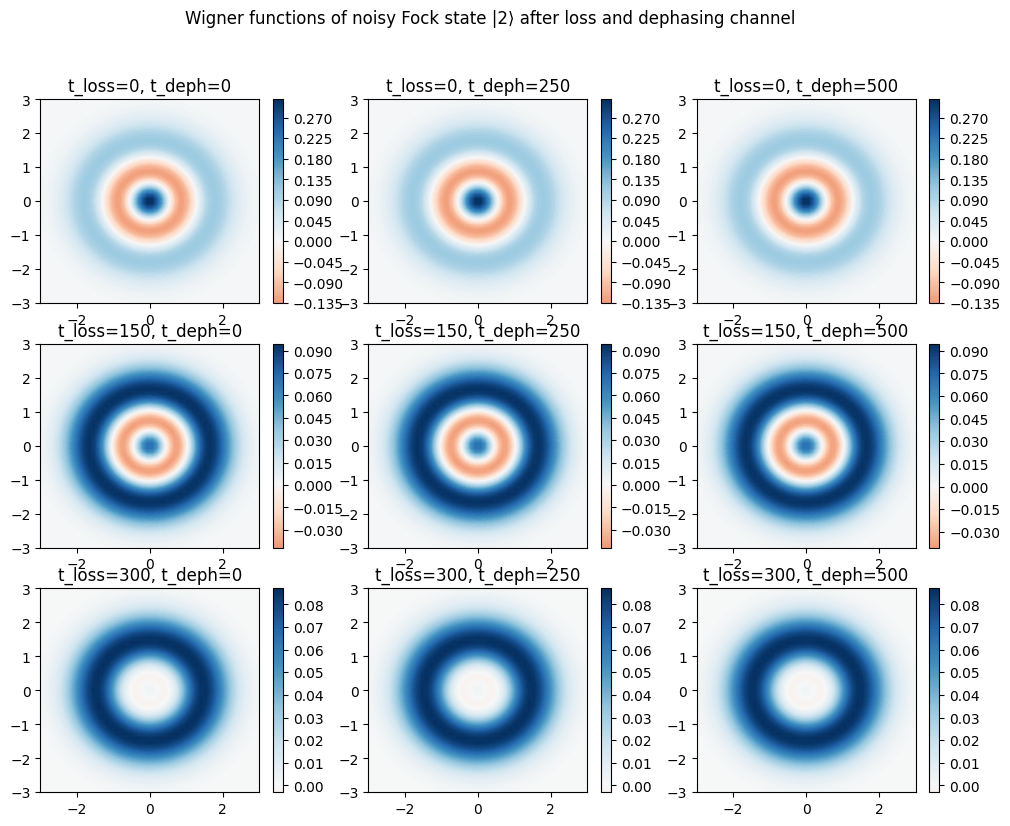

In [31]:
N = 11
nb_plots_x = 3
nb_plots_y = 3
t_list_dephase = np.linspace(0, 500, nb_plots_y)
t_list_loss = np.linspace(0, 300, nb_plots_x)
rho_0 = qutip.fock_dm(N, 2) #qutip.ket2dm((qutip.fock(N, 0) + qutip.fock(N,4)).unit())
rho_list_losses = create_states(N, t_list_loss, rho_0, kappa)
rho_list = [create_states_dephasing(N, t_list_dephase, rho, kappa) for rho in rho_list_losses]
bound = 3
xvec, yvec = np.linspace(-bound,bound,50), np.linspace(-bound,bound,50)
# create several plots for different elements of rho_list
f, axes = plt.subplots(nb_plots_y, nb_plots_x, figsize=(4*nb_plots_x, 3*nb_plots_y))
for i in range(nb_plots_y):
    for j in range(nb_plots_x):
        plot_wigner(rho_list[i][j], xvec, yvec, f, axes[i][j], 'RdBu',
                    f"t_loss={t_list_loss[i]:.0f}, t_deph={t_list_dephase[j]:.0f}", density=True)
#f.suptitle("Wigner functions of noisy binomial state\n(|0⟩ + |4⟩)/√2 after dephasing channel")
f.suptitle("Wigner functions of noisy Fock state |2⟩ after loss and dephasing channel")

## ----- Plots for report and tests ------

Text(0, 0.5, 'Coefficient')

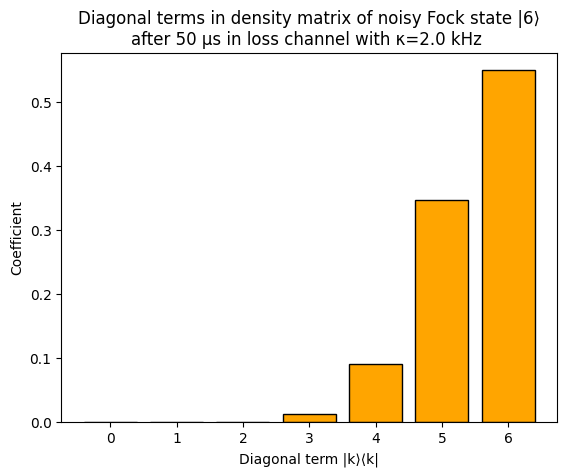

In [32]:
N=10
n=6
t=50
rho = create_states(N, [t], qutip.fock_dm(N,n), kappa, 1)[0]
plt.bar(np.arange(n+1),np.abs(np.diag(rho))[:n+1], color='orange', linestyle='-', edgecolor='black')
plt.title(f"Diagonal terms in density matrix of noisy Fock state |{n}⟩\nafter {t} μs in loss channel with κ={1000*kappa} kHz ")
plt.xlabel("Diagonal term |k⟩⟨k|")
plt.ylabel("Coefficient")

Here we cheat a little bit to have a nice-looking plot, but we verify immediately after that it was possible

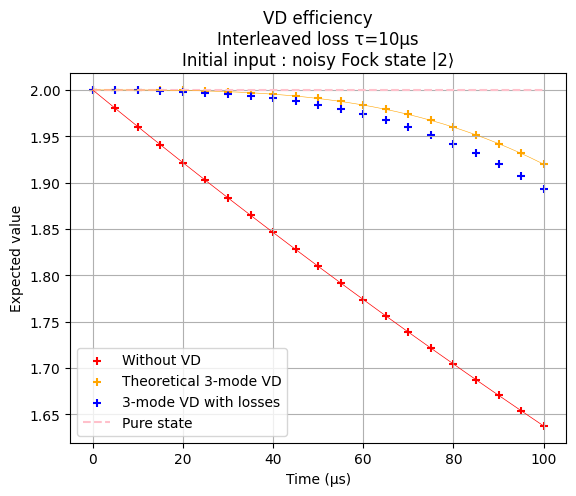

In [33]:
# same t_list as the beginning
import qutip
from functions import *
t_max = 120
N=15
n=2
nb_samples = 25
T_1=500 # μs
kappa = 1/T_1
t_list_large = np.linspace(0,t_max,nb_samples)
t_list = t_list_large[:21]
rho_list = create_states(N, t_list_large, rho_0 = qutip.fock_dm(N,n), kappa=kappa)

r, r_loss, r_th = perform_protocol(N, rho_list, [], [1,3], False, None)
r_th_1, r_th_3 = r_th

plt.scatter(t_list, np.abs(r_th_1)[:21], label="Without VD", marker='+', c='r')
plt.scatter(t_list, np.abs(r_th_3)[:21], label="Theoretical 3-mode VD", marker='+', c='orange')
tau = 10 # μs
plt.scatter(t_list, np.abs(r_th_3)[tau//5:23], label=f"3-mode VD with losses", marker='+', c='b')

plt.plot(t_list,np.full(t_list.shape,(r_th_1[0]).real),
            linestyle="--", label='Pure state', c='pink')

t_list_complete = np.linspace(t_list[0], t_list[-1], 1000)
no_VD_curve_th = n * np.exp(-kappa * t_list_complete)
plt.plot(t_list_complete, no_VD_curve_th, c='r', linewidth = 0.5)
temporary = (np.exp(kappa * t_list_complete)-1)
VD_3_curve_th = (2+8*temporary**3)/(1+8*temporary**3+temporary**6)
plt.plot(t_list_complete, VD_3_curve_th, c='orange', linewidth =0.4)

plt.title(f"VD efficiency" +
            f"\nInterleaved loss τ={tau}µs" +
            f"\nInitial input : noisy "+"Fock state |2⟩")
plt.xlabel(f"Time (µs)")
plt.ylabel("Expected value")
plt.legend()
plt.grid()
plt.show()

We could have run this immediately but I prefered without the error bars:

In [35]:
initial_sin_angles = np.sqrt((1/2,1/3,1/2)) # exact values
# F3 = create_F3(N, initial_sin_angles, np.zeros(3))
# r, r_loss, r_th = perform_protocol(N, rho_list[:21], [F3], [1,3], dephasing=True,
#                                   dephasing_gamma=tau*kappa/3, print_progression=True)
# r_th_1, r_th_3 = r_th
# plot_all(t_list, r, r_loss, [(r_th_1, "Without VD"), (r_th_3, "Theoretical 3-mode VD")],
#            title=f"Fock state |2>", eps_std=0, gamma_dephasing=tau*kappa, kappa=kappa)

### Why is there symmetry breaking for noisy Fock states??

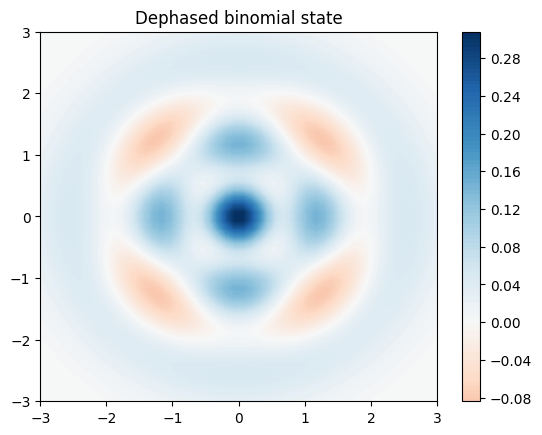

In [36]:
rho = qutip.ket2dm((qutip.fock(N, 0) + qutip.fock(N, 4)).unit())
rho_dephased = create_states_dephasing(N, [50], rho, kappa)[0]
bound = 3
xvec, yvec = np.linspace(-bound,bound,50), np.linspace(-bound,bound,50)
plot_wigner(rho_dephased, xvec, yvec, plt.figure(), plt.gca(), 'RdBu', "Dephased binomial state", density=True)

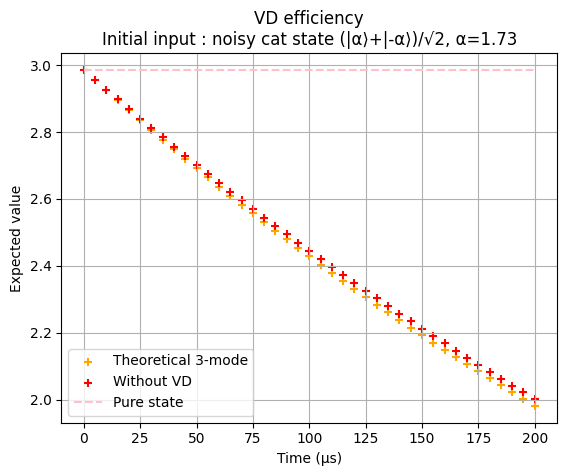

In [127]:
N_ = 13
t_list_gkp = np.linspace(0, 200, 41)
delta = 0.4
alpha = np.sqrt(3)
psi_gkp = cat_state(alpha,N_) #gkp_state(delta, N_)
rho_gkp = qutip.ket2dm(psi_gkp)
noisy_gkp_list = create_states(N_, t_list_gkp, rho_gkp, kappa)

F_list = [] #[create_F3(N_, np.sqrt((1/2,1/3,1/2)), np.zeros(3))]

result_gkp, result_gkp_loss, result_gkp_th = perform_protocol(N_,noisy_gkp_list, F_list,
                                                                  [1,3], losses=False)
plot_all(t_list_gkp, result_gkp, result_gkp_loss, [(result_gkp_th[1], "Theoretical 3-mode"),
                        (result_gkp_th[0], "Without VD")], None, f"cat state (|α⟩+|-α⟩)/√2, α={alpha:.2f}", 
                        eps_std=0,gamma_loss=None, show_only_th=True)

In [38]:
N_ = 50
rho_gkp = qutip.ket2dm(gkp_state(delta, N_))
print(qutip.expect(qutip.num(N_), rho_gkp))

2.6426925175432276


In [39]:
N_ = 10
rho_gkp = qutip.ket2dm(gkp_state(delta, N_))
rho_full=qutip.tensor([rho_gkp]*3)
bs1, bs2, bs3 = create_F3(N_, np.sqrt((1/2,1/3,1/2)), np.zeros(3))
rho_tilde = bs1*bs2*bs3*rho_full*bs3.dag()*bs2.dag()*bs1.dag()

n1 = qutip.tensor(qutip.num(N_),  qutip.identity(N_), qutip.identity(N_))
n2 = qutip.tensor(qutip.identity(N_), qutip.num(N_),  qutip.identity(N_))
n3 = qutip.tensor(qutip.identity(N_), qutip.identity(N_), qutip.num(N_))
denominator_op = (2j*np.pi/3*(n1+2*n2)).expm()
numerator_op = (n1+n2+n3)/3 * denominator_op

print(qutip.expect(qutip.num(N_), rho_gkp))

print(qutip.expect(numerator_op, rho_tilde)/qutip.expect(denominator_op, rho_tilde))

2.094111576258963
(1.877899613122971+0.009244272272648272j)


## Cat state tests

In [103]:
t_max = 100
N=12
n=2
nb_samples = 10
T_1=500 # μs
kappa = 1/T_1
t_list = np.linspace(0,t_max,nb_samples)
rho_list = create_states(N, t_list, rho_0 = qutip.ket2dm(cat_state(0.5, N)),
                         kappa=kappa)

eps_std, nb_F_samples = 0,1 #0.001, 1
noise_list = np.random.normal(0,eps_std,(nb_F_samples,3))
F_list = [] # list of triplets of beam splitters
for (i,noise) in enumerate(noise_list):
    if (i%1==0): print(f"{i+1}/{nb_F_samples}", end=" ")
    F_list.append(create_F3(N, np.sqrt((1/2,1/3,1/2)), noise))

r, r_loss, r_th = perform_protocol(N, rho_list, F_list, [1,3], False, None, print_progression=True)
r_th_1, r_th_3 = r_th

1/1 1/10 2/10 3/10 4/10 5/10 6/10 7/10 8/10 9/10 10/10 

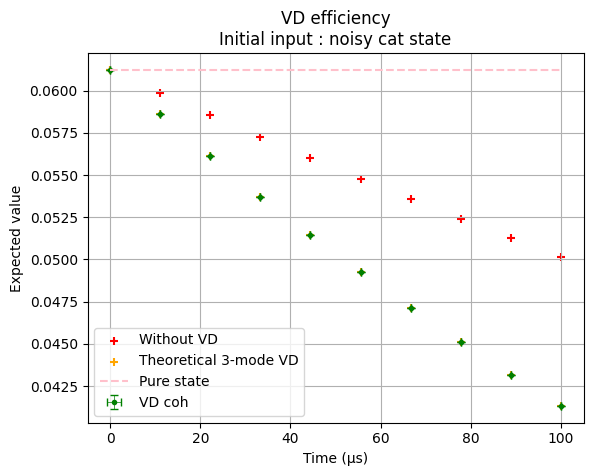

In [104]:

plt.scatter(t_list, np.abs(r_th_1), label="Without VD", marker='+', c='r')
plt.scatter(t_list, np.abs(r_th_3), label="Theoretical 3-mode VD", marker='+', c='orange')
plt.errorbar(t_list, np.abs(r.mean(1)), r.std(1), np.zeros_like(t_list), 
    barsabove=True, elinewidth=.5,fmt='.',label="VD coh", c='g', capsize=3)

plt.plot(t_list,np.full(t_list.shape,(r_th_1[0]).real),
            linestyle="--", label='Pure state', c='pink')

plt.title(f"VD efficiency" +
            f"\nInitial input : noisy "+"cat state")
plt.xlabel(f"Time (µs)")
plt.ylabel("Expected value")
plt.legend()
plt.grid()
plt.show()

In [92]:
from functions import *
N=11
rho = qutip.ket2dm((qutip.fock(N,4)+qutip.fock(N,0)).unit())#qutip.ket2dm(cat_state(0.5, N)) #qutip.coherent_dm(N, 1.5) # qutip.ket2dm(gkp_state(0.4, N)) #qutip.fock_dm(N, 2) #  
rho_3 = qutip.tensor([rho]*3)

n1 = qutip.tensor(qutip.num(N),  qutip.identity(N), qutip.identity(N))
n2 = qutip.tensor(qutip.identity(N), qutip.num(N),  qutip.identity(N))
n3 = qutip.tensor(qutip.identity(N), qutip.identity(N), qutip.num(N))
denominator_op = (2j*np.pi/3*(n1+2*n2)).expm()
numerator_op = (n1+n2+n3)/3 * denominator_op
bs1, bs2, bs3 = create_F3(N, np.sqrt((1/2,1/3,1/2)), np.zeros(3), prepost = False)

ps1 = (-5j*np.pi/6*qutip.num(N)).expm()
ps2 = (-2j*np.pi/3*qutip.num(N)).expm()
prephase_op = qutip.tensor(ps1, ps2, qutip.identity(N))

ps_end_1 = (-1j*np.pi/2*qutip.num(N)).expm()
ps_end_2 = (-1j*np.pi/2*qutip.num(N)).expm()
postphase_op = qutip.tensor(ps_end_1, ps_end_2, qutip.identity(N))

full_F3 = prephase_op*bs1*bs2*bs3*postphase_op
old_F3 = bs1*bs2*bs3

rho_tilde = full_F3 * rho_3 * full_F3.dag()
print("New F3:", qutip.expect(denominator_op, rho_tilde)) # qutip.expect(numerator_op, rho_tilde)
print("Old F3:", qutip.expect(denominator_op, old_F3*rho_3*old_F3.dag())) # qutip.expect(numerator_op, old_F3*rho_3*old_F3.dag())

New F3: (0.9601933512863189+0.0004315181973898166j)
Old F3: (0.9601933512863189+0.0004315181973898151j)


In [43]:
S_complex = full_F3.dag() * denominator_op * full_F3
S = qutip.Qobj((np.abs(S_complex.full())), dims=S_complex.dims, shape=S_complex.shape, type=S_complex.type)

print((rho_3 * S_complex).tr())

#print(((n1+n2+n3)/3 * S * rho_3).tr(), (rho_3 * S).tr(), " better result by brutally truncating onto 0 and 1")

0.9999999999873855


In [44]:
print(qutip.expect(qutip.num(N), rho**3), (rho**3).tr()) # what we expect

0.06122966559842756 0.9999999999997351


In [45]:
def S_coef(S, i1, i2, i3, j1, j2, j3):
    ''' Returns the coefficient of the operator S_ij in the density matrix'''
    return (qutip.fock([N,N,N], [i1, i2, i3]).dag() * S * qutip.fock([N,N,N], [j1, j2, j3])).full()[0][0]
S_coef(S_complex, 2,2,2,2,2,2)

(0.9999999999999999+0j)

In [46]:
N_trunc = 1 # 5
res = 0
rho_mat = rho.full()
for i1 in range(N_trunc):
    for i2 in range(N_trunc):
        for i3 in range(N_trunc):
            for j1 in range(N_trunc):
                for j2 in range(N_trunc):
                    for j3 in range(N_trunc):
                        c = S_coef(S_complex, i1,i2,i3,j1,j2,j3)
                        res += abs(c)*rho_mat[i1][j1]*rho_mat[i2][j2]*rho_mat[i3][j3]
                        if abs(c)>1e-3 and abs(c) < 1 - 1e-3:
                            print(f"S_{i1} {i2} {i3} {j1} {j2} {j3} = {c}")
res

(0.9113854079573767+0j)

In [47]:
abs(0.6692939457957272+0.35668145306552246j)
S_complex.check_isunitary()

True

### Problem identified
S is complex whereas it should be only zeroes and ones

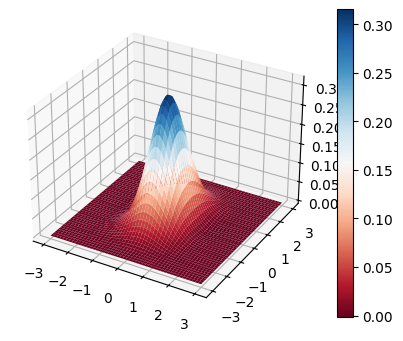

In [48]:
f, ax = plt.subplots(1, 1, figsize=(5,4), subplot_kw={"projection": "3d"})
wigner = qutip.wigner(rho, xvec, yvec)
X = np.tile(xvec, (len(yvec), 1)).transpose()
Y = np.tile(yvec, (len(xvec), 1))
plot = ax.plot_surface(X, Y, wigner, cmap='RdBu')
fig.colorbar(plot, ax=ax)

In [49]:
wigner.shape

(50, 50)

## Tests for quadrature measurement

In [50]:
from qutip.measurement import measure
N=50
q_quad_observable = (qutip.destroy(N) + qutip.create(N))/np.sqrt(2)
p_quad_observable = -1j*(qutip.destroy(N) - qutip.create(N))/np.sqrt(2)

psi_fock = qutip.fock(N, 2)
for i in range(10):
    res, _ = measure(psi_fock, (q_quad_observable**2+p_quad_observable**2-1)/2)
    th_res, _ = measure(psi_fock, qutip.num(N))
    print(f"(q^2+p^2-1)/2: {res:.3f},  n: {th_res:.3f}")

(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000


-0.15630254688947076

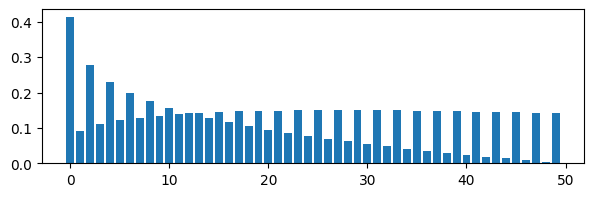

In [51]:
psi_init = qutip.fock(N, 2)
val, psi_proj = measure(psi_init, q_quad_observable)
plt.figure(figsize=(7,2))
plt.bar(np.arange(N), np.abs(psi_proj.full().flatten()))
val

In [52]:
for i in range(5): print(measure(psi_proj, q_quad_observable)[0])

-0.15630254688947076
-0.15630254688947076
-0.15630254688947076
-0.15630254688947076
-0.15630254688947076


In [128]:
N=11
nb_samples = 21
t_list = np.linspace(0, 300, nb_samples)
kappa_phi = 1/500
rho_coh = qutip.ket2dm(qutip.coherent(N, 0.6)) #+0.3j))
rho_coh_list = create_states_dephasing(N, t_list, rho_coh, kappa_phi)
q_operator = (qutip.destroy(N) + qutip.create(N))/np.sqrt(2)

eps_std, nb_F_samples = 0.1, 5
noise_list = np.random.normal(0,eps_std,(nb_F_samples,3))
F3_list = [] # this time we store the whole gate
print("F3 samples:", end=" ")
for i in range(nb_F_samples):
    bs1, bs2, bs3 = create_F3(N, np.sqrt((1/2,1/3,1/2)), noise_list[i])
    print(f"{i+1}/{nb_F_samples}", end=" ")
    F3_list.append(bs1*bs2*bs3)

temp = (2j*np.pi/3*(qutip.tensor(qutip.num(N), qutip.identity(N))+2*qutip.tensor(qutip.identity(N), qutip.num(N)))).expm()
denominator_op = qutip.tensor(temp, qutip.identity(N))
numerator_op = qutip.tensor(temp, q_operator) / np.sqrt(3)
results = np.zeros((nb_samples, nb_F_samples), dtype='complex')
print("Points:", end=" ")
for (i,rho) in enumerate(rho_coh_list):
    for (j, F3) in enumerate(F3_list):
        rho_3 = qutip.tensor([rho]*3)
        rho_tilde = F3*rho_3*F3.dag()
        results[i,j] = qutip.expect(numerator_op, rho_tilde)/qutip.expect(denominator_op, rho_tilde)
    print(f"{i+1}/{len(rho_coh_list)}", end=" ")

F3 samples: 1/5 2/5 3/5 4/5 5/5 Points: 1/21 2/21 3/21 4/21 5/21 6/21 7/21 8/21 9/21 10/21 11/21 12/21 13/21 14/21 15/21 16/21 17/21 18/21 19/21 20/21 21/21 

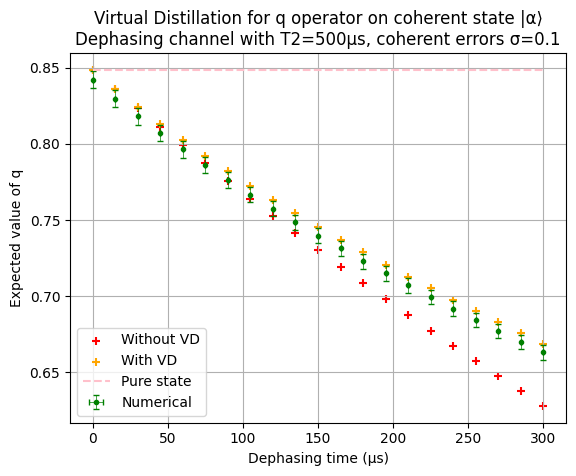

In [129]:
plt.scatter(t_list, [qutip.expect(q_operator, rho) for rho in rho_coh_list], label="Without VD", c='r', marker='+')
plt.scatter(t_list, [qutip.expect(q_operator, rho**3)/(rho**3).tr() for rho in rho_coh_list], label="With VD", c='orange', marker='+')
plt.errorbar(t_list, np.abs(results.mean(1)), results.std(1), np.zeros_like(t_list), 
            barsabove=True, elinewidth=.5,fmt='.',capsize=2, label="Numerical", c='green')
plt.plot(t_list, np.full_like(t_list, (q_operator*rho_coh).tr().real), label="Pure state", c='pink', linestyle='dashed')
plt.title(f"Virtual Distillation for q operator on coherent state |α⟩\n"+
          f"Dephasing channel with T2={1/kappa:.0f}μs, coherent errors σ={eps_std:.1f}")
plt.xlabel("Dephasing time (μs)")
plt.ylabel("Expected value of q")
plt.grid()
plt.legend()

## Trying dephased inputs for number operator

In [2]:
import qutip
from functions import *

N=30
nb_samples = 21
t_list = np.linspace(0, 200, nb_samples)
kappa_phi = 1/500
rho_list = [(qutip.ket2dm(qutip.coherent(N, 1.3+0.3j)), "Coherent"), #+0.3j))
            (qutip.ket2dm(gkp_state(0.4, N)), "GKP"),
            # squeezed coherent state
            (qutip.ket2dm(qutip.squeeze(N, 0.5)*qutip.coherent(N, 1.3+0.3j)), "Squeezed coherent"),
            (qutip.ket2dm(cat_state(0.5, N)), "Cat")]
rho_dephased_list = [create_states_dephasing(N, t_list, rho, kappa_phi) for rho, _ in rho_list]

Text(0.5, 0.98, 'Virtual Distillation for number operator on dephased states\nDephasing channel with T2=500μs')

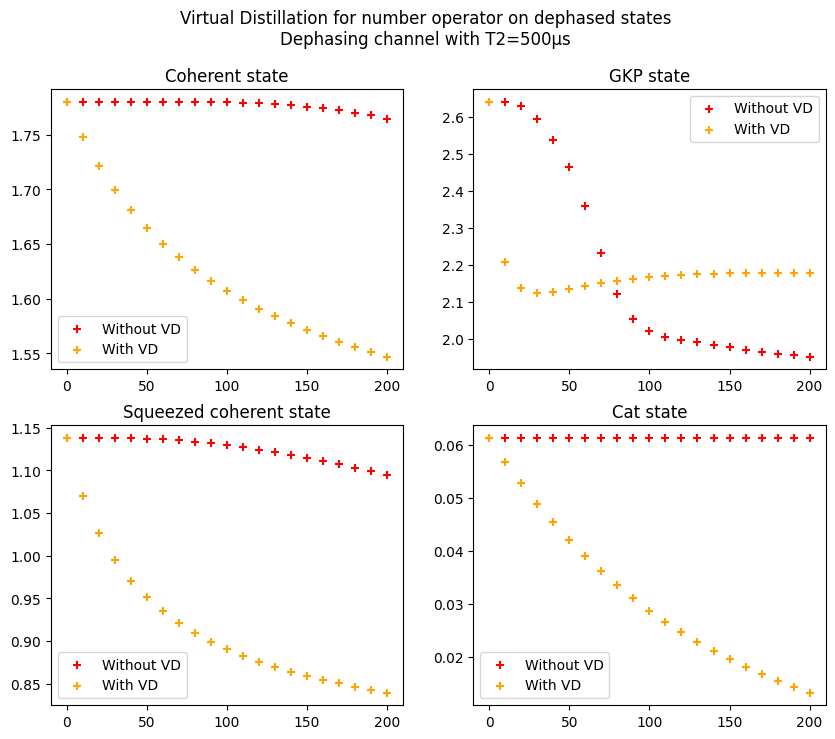

In [3]:
f, ax = plt.subplots(2, 2, figsize=(10,8))
operator = qutip.num(N)
for (i,j) in np.array(np.meshgrid([0,1],[0,1])).T.reshape(-1,2):
    ind = 2*i+j
    ax[i][j].scatter(t_list, [qutip.expect(operator, rho) for rho in rho_dephased_list[ind]],
                     label="Without VD", c='r', marker='+')
    ax[i][j].scatter(t_list, [qutip.expect(operator, rho**3)/(rho**3).tr() for rho in rho_dephased_list[ind]],
                     label="With VD", c='orange', marker='+')
    ax[i][j].set_title(f"{rho_list[ind][1]} state")
    ax[i][j].legend()
f.suptitle("Virtual Distillation for number operator on dephased states\n"+
          f"Dephasing channel with T2={1/kappa_phi:.0f}μs")

Quadrature measurement on squeezed coherent

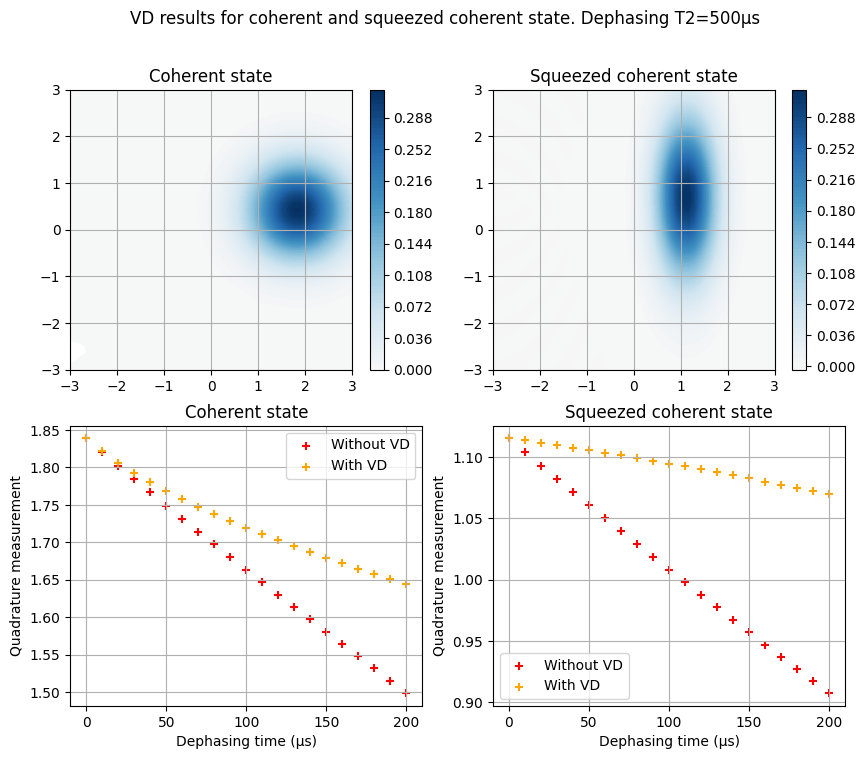

In [12]:
operator = (qutip.destroy(N) + qutip.create(N))/np.sqrt(2)
f, ax = plt.subplots(2, 2, figsize=(10,8))
f.suptitle("VD results for coherent and squeezed coherent state. "+
           f"Dephasing T2={1/kappa_phi:.0f}μs")
xvec, yvec = np.linspace(-3,3,50), np.linspace(-3,3,50)
ax[0][0].grid(), ax[0][1].grid()
plot_wigner(rho_list[0][0], xvec, yvec, f, ax[0][0], 'RdBu', "Coherent state", density=True)
plot_wigner(rho_list[2][0], xvec, yvec, f, ax[0][1], 'RdBu', "Squeezed coherent state", density=True)
#ax=[[], ax]
for i in range(2):
    ax[1][i].scatter(t_list, [qutip.expect(operator, rho) for rho in rho_dephased_list[2*i]],
                     label="Without VD", c='r', marker='+')
    ax[1][i].scatter(t_list, [qutip.expect(operator, rho**3)/(rho**3).tr() for rho in rho_dephased_list[2*i]],
                     label="With VD", c='orange', marker='+')
    ax[1][i].set_title(f"{rho_list[2*i][1]} state")
    ax[1][i].set_xlabel("Dephasing time (μs)")
    ax[1][i].set_ylabel("Quadrature measurement")
    ax[1][i].legend()
    ax[1][i].grid()